In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


In [4]:
df = pd.read_csv("spam.csv", encoding="latin-1")

df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [7]:
df = df.dropna(how="any", axis=1)
df.columns = ['Target', 'Message']

df.head(10)

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


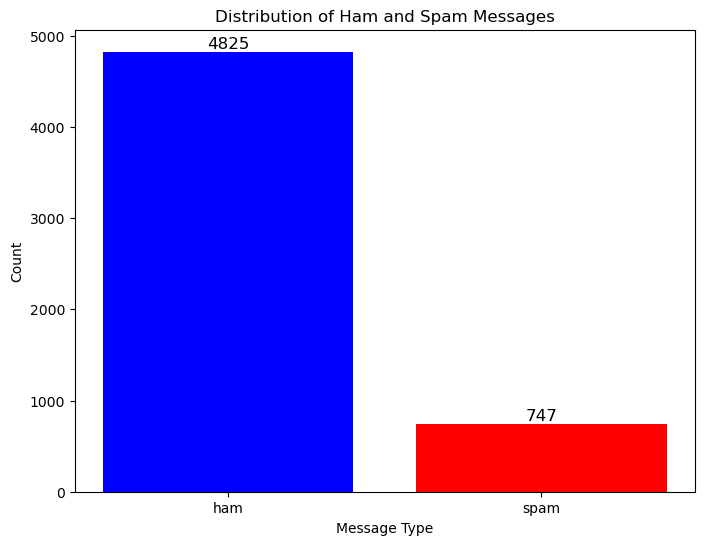

In [10]:
label_counts = df['Target'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center', fontsize=12)


plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Messages')
plt.show()

In [12]:
df['length'] = df['Message'].apply(lambda x: len(x.split(' ')))

ham_length = df[df['Target'] == 'ham']['length']
spam_length = df[df['Target'] == 'spam']['length']


print(f'Max length of ham message: {max(ham_length)}')
print(f'Max length of spam message: {max(spam_length)}')

Max length of ham message: 171
Max length of spam message: 35


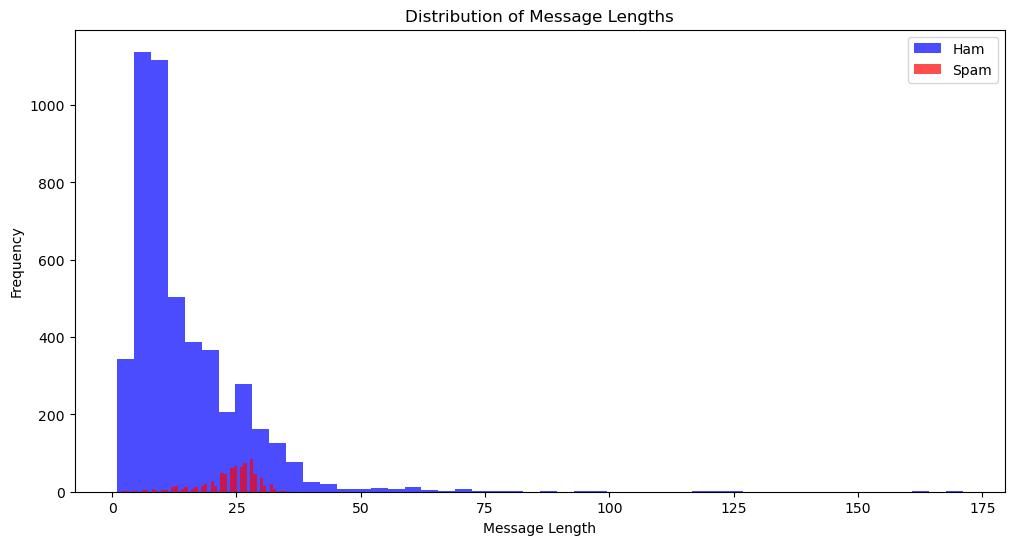

In [14]:
plt.figure(figsize=(12, 6))


plt.hist(ham_length, bins=50, alpha=0.7, label='Ham', color='blue')

plt.hist(spam_length, bins=50, alpha=0.7, label='Spam', color='red')

plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [16]:
def remove_punc(text):
    
    url_pattern = r'https?://\S+|www\.\S+'
    mention_pattern = r'@\w+'
    
   
    text = re.sub(url_pattern, '', text)  
    text = re.sub(mention_pattern, '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text.strip()

df['wo_punc'] = df['Message'].apply(lambda text: remove_punc(text))

In [18]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df["wo_stop"] = df["wo_punc"].apply(lambda text: remove_stopwords(text))

In [19]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["stemmed_text"] = df["wo_stop"].apply(lambda text: stem_words(text))

df.head(10)

,Target,Message,length,wo_punc,wo_stop,stemmed_text
0,ham,"Go until jurong point, crazy.. Available only ...",20,Go until jurong point crazy Available only in ...,Go jurong point crazy Available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,Ok lar Joking wif u oni,Ok lar Joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,11,U dun say so early hor U c already then say,U dun say early hor U c already say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,Nah I dont think he goes to usf he lives aroun...,Nah I dont think goes usf lives around though,nah i dont think goe usf live around though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,32,FreeMsg Hey there darling its been 3 weeks now...,FreeMsg Hey darling 3 weeks word back Id like ...,freemsg hey darl 3 week word back id like fun ...
6,ham,Even my brother is not like to speak with me. ...,16,Even my brother is not like to speak with me T...,Even brother like speak They treat like aids p...,even brother like speak they treat like aid pa...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,26,As per your request Melle Melle Oru Minnaminun...,As per request Melle Melle Oru Minnaminunginte...,as per request mell mell oru minnaminungint nu...
8,spam,WINNER!! As a valued network customer you have...,26,WINNER As a valued network customer you have b...,WINNER As valued network customer selected rec...,winner as valu network custom select receivea ...
9,spam,Had your mobile 11 months or more? U R entitle...,29,Had your mobile 11 months or more U R entitled...,Had mobile 11 months U R entitled Update lates...,had mobil 11 month u r entitl updat latest col...


In [20]:
X = df['stemmed_text']
y = df['Target']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4179,) (4179,)
(1393,) (1393,)


In [21]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 6844


In [22]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [23]:
y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.95
Precision: 0.98
Recall: 0.64
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1202
        spam       0.98      0.64      0.77       191

    accuracy                           0.95      1393
   macro avg       0.96      0.82      0.87      1393
weighted avg       0.95      0.95      0.94      1393


Confusion Matrix:
[[1199    3]
 [  69  122]]
